In [2]:
import sys
import numpy
import pandas
import xgboost
import lightgbm
import sklearn

# print('python :', sys.version)
# print('numpy :', numpy.__version__)
# print('pandas :', pandas.__version__)
# print('scikit-learn :', sklearn.__version__)
# print('lightgbm :', lightgbm.__version__)
# print('xgboost :', xgboost.__version__)

# 📍📍 train + test

In [5]:
import pandas as pd
import numpy as np

train = pd.read_csv('/Users/pycode/1_project/데이터/train.csv')
# train.info()
# train.head()
# train.isna().sum()

In [6]:

test = pd.read_csv('/Users/pycode/1_project/데이터/test.csv')
# test.info()
# test.head()
test.isna().sum()

ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64

## 📍 데이터 타입 지정
* train, test 합치기 전에 데이터 타입 지정   
train -> 데이터타입 : 'train'    
test -> 데이터타입 : 'test' 
* concat으로 train + test

In [7]:
train['데이터타입'] = 'train'
test['데이터타입'] = 'test'
total_data = pd.concat([train.drop(columns='허위매물여부'), test])

# total_data.info()

## 📍 train + test 후 파생변수 생성
* 미기재
* 방치일수
* 집세

In [8]:
import datetime

# 미기재
total_data['미기재'] = total_data.isna().sum(axis=1)

# 방치일수
last = datetime.datetime.strptime(total_data['게재일'].max(), "%Y-%m-%d").date()
today = last + datetime.timedelta(days=1)

def get_delta_day(date):
    delta = today - datetime.datetime.strptime(date, "%Y-%m-%d").date()
    return delta.days

total_data['방치일수'] = total_data['게재일'].apply(lambda x: get_delta_day(x))

# 집세
total_data['집세'] = total_data['관리비'] * 10000 + total_data['월세']

# total_data.head()

## 📍 train + test 후 결측치 처리

### 1. 방수, 욕실수   
  -> 가장 많은 수인 1로 채움

In [9]:
room = total_data['방수'].value_counts()
bath = total_data['욕실수'].value_counts()
print(room)
print(bath)

total_data[['방수', '욕실수']] = total_data[['방수', '욕실수']].fillna(1.0)

방수
1.0    1881
2.0    1166
Name: count, dtype: int64
욕실수
1.0    2940
2.0     105
Name: count, dtype: int64


### 2. 전용면적   
  -> 방수, 욕실수 조합으로 전용면적 평균 및 적용

In [11]:
dropna_total = total_data.dropna(subset=['전용면적'], how='any', axis=0)
new_data = pd.DataFrame(dropna_total, columns=('방수', '욕실수', '전용면적'))

mean_data = new_data.groupby(['방수', '욕실수'], as_index=False).mean()
print(mean_data)

for index, row in total_data.iterrows():
    if (pd.isna(row['전용면적'])):
        filterTrain = mean_data[(mean_data['방수'] == row['방수']) & (mean_data['욕실수'] == row['욕실수'])]
        total_data.at[index, '전용면적'] = filterTrain['전용면적'].values[0]

# total_data.head()

    방수  욕실수       전용면적
0  1.0  1.0  25.588143
1  2.0  1.0  31.825224
2  2.0  2.0  26.878712


### 3. 해당층, 총층   
  -> 평균을 반올림하여 적용

In [12]:
room = round(total_data['해당층'].mean())
bath = round(total_data['총층'].mean())
print(room)
print(bath)
total_data['해당층'] = total_data['해당층'].fillna(room)
total_data['총층'] = total_data['총층'].fillna(bath)

# total_data.isna().sum()

5
8


### 4. 총주차대수
-> 평균을 반올림하여 적용

In [160]:
parking = round(total_data['총주차대수'].mean())
total_data['총주차대수'] = total_data['총주차대수'].fillna(parking)

## 📍 보증금, 월세, 관리비 단위 정리

In [13]:
total_data['보증금'] = total_data['보증금'] / 10000
total_data['월세'] = total_data['월세'] / 10000
total_data['집세'] = total_data['집세'] / 10000
# total_data['관리비'] = total_data['관리비'] * 10000
# total_data.head()

---------------

# 📍📍 Feature Scaling
-> MinMaxScaler 사용

In [20]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler객체 생성
scaler = MinMaxScaler()
# MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
cols_for_scale = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '미기재', '방치일수', '집세']
scaler.fit(total_data[cols_for_scale])
total_data[cols_for_scale] = scaler.transform(total_data[cols_for_scale])
print(total_data)

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
total_data_scaled = pd.DataFrame(data=total_data, columns=total_data.columns)
# print('feature들의 최솟값')
# print(total_data_scaled.min())
# print('\nfeature들의 최댓값')
# print(total_data_scaled.max())
# # total_data_scaled.head()

             ID 매물확인방식       보증금        월세      전용면적   해당층        총층   방향  \
0    TRAIN_0000   현장확인  0.874587  0.626667  0.235923  0.20  0.684211   서향   
1    TRAIN_0001   현장확인  0.364136  0.266667  0.452772  0.10  0.105263  남동향   
2    TRAIN_0002   전화확인  0.239824  0.506667  0.235923  0.05  0.052632   동향   
3    TRAIN_0003   현장확인  0.348735  0.040000  0.578996  0.10  0.368421  남동향   
4    TRAIN_0004   현장확인  0.750275  0.706667  0.452772  0.10  0.052632   동향   
..          ...    ...       ...       ...       ...   ...       ...  ...   
608    TEST_608   현장확인  0.324532  0.453333  0.410533  0.15  0.210526  남동향   
609    TEST_609   전화확인  0.487349  1.000000  0.452772  0.20  0.421053  남서향   
610    TEST_610   현장확인  0.361936  0.666667  0.235923  0.20  0.210526   남향   
611    TEST_611   현장확인  0.385039  0.453333  0.452772  0.10  0.210526  남동향   
612    TEST_612   현장확인  0.303630  0.480000  0.110564  0.45  0.684211   동향   

      방수  욕실수 주차가능여부     총주차대수       관리비       중개사무소 제공플랫폼         게재일  데이터

# 📍📍 train, test 데이터 분리

In [15]:
total_data_prepro = total_data_scaled
train_data = total_data_prepro[total_data_prepro['데이터타입'] == 'train']
test_data = total_data_prepro[total_data_prepro['데이터타입'] == 'test']
# print(train_data.head())
# print("-" * 10)
# print(test_data.head())

# def set_false(data) :
#     tttt = train[train['ID'] == data]
#     return tttt['허위매물여부'].values[0]

# train_data["허위매물여부"] = train_data["ID"].apply(lambda x : set_false(x))

train_data["허위매물여부"] = train.set_index("ID").loc[train_data["ID"], "허위매물여부"].values

# train_data = train_data.drop(columns=['게재일', '데이터타입'])
# test_data = test_data.drop(columns=['게재일', '데이터타입'])
train_data_mo = train_data.drop(columns=['ID', '게재일', '데이터타입'])
test_data_mo = test_data.drop(columns=['ID', '게재일', '데이터타입'])
# print(train_data_mo.head())
# print(test_data_mo.head())

# train_data, test_data 파일로 저장
# modified_train_data = train_data.drop(columns='데이터타입')
# modified_test_data = test_data.drop(columns='데이터타입')
# modified_train_data.to_csv("/Users/pycode/project/데이터/modified_train.csv", index = False)
# modified_test_data.to_csv("/Users/pycode/project/데이터/modified_test.csv", index = False)

/var/folders/vf/7_3tcw7s7l1cqg5rdfjpnwf00000gn/T/ipykernel_73961/4210710536.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["허위매물여부"] = train.set_index("ID").loc[train_data["ID"], "허위매물여부"].values


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 데이터 로드
df = train_data_mo

# 다수 클래스(정상 매물)와 소수 클래스(허위 매물) 분리
df_majority = df[df['허위매물여부'] == 0]  # 정상 매물 (2100개)
df_minority = df[df['허위매물여부'] == 1]  # 허위 매물 (300개)

# 정상 매물을 K-Means 클러스터링하여 300개로 압축
n_clusters = len(df_minority)  # 허위 매물 개수(300개)와 동일한 개수로 설정
print(n_clusters)

# K-Means 클러스터링을 위한 특성 선택 (수치형 변수만 사용)
numeric_features = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '관리비', '총주차대수']
df_majority_numeric = df_majority[numeric_features].dropna()  # 결측값 제거
# print(df_majority_numeric)

# # 표준화 (K-Means는 거리 기반이므로 스케일링 필요)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_majority_numeric)
# print(X_scaled)

X_scaled = df_majority_numeric

# K-Means 모델 학습
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df_majority_numeric['cluster'] = kmeans.fit_predict(X_scaled)
df_majority_numeric.shape()

# # 각 클러스터에서 대표 샘플 선택 (가장 중심에 가까운 샘플)
# df_majority_numeric['distance'] = np.linalg.norm(X_scaled - kmeans.cluster_centers_[df_majority_numeric['cluster']], axis=1)
# df_majority_downsampled = df_majority.loc[df_majority_numeric.groupby('cluster')['distance'].idxmin()]

# # 다운샘플링된 데이터셋 생성
# df_balanced = pd.concat([df_majority_downsampled, df_minority])

# # 결과 확인
# print(df_balanced['허위매물여부'].value_counts())  # 0과 1이 300개로 맞춰짐


298


ValueError: Unable to coerce to DataFrame, shape must be (1580, 10): given (1580, 9)

# 📍📍 SMOTENC 오버샘플링

In [164]:
from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
# train_data_mo
# X, y = make_classification(
#     n_classes=2, class_sep=2,
#     weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#     n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10
# )
X_train = train_data_mo.iloc[:, :-1]
y_train = train_data_mo.iloc[:, -1]

# print(X_train.columns)
# categorical = [idx for idx, dtype in enumerate(X_train.dtypes) if dtype == 'int64']
cat_col_name = [0, 6, 9, 12, 13]
# cat_col_name = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼'],

print(f'Original dataset shape {X_train.shape}')
print(f'Original dataset samples per class {Counter(y_train)}')

# simulate the 2 last columns to be categorical features
# X_train[:, -2:] = RandomState(10).randint(0, 4, size=(1000, 2))
sm = SMOTENC(random_state=42, categorical_features=cat_col_name, k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(f'Resampled dataset samples per class {Counter(y_res)}')

Original dataset shape (2452, 17)
Original dataset samples per class Counter({0: 2154, 1: 298})


Resampled dataset samples per class Counter({0: 2154, 1: 2154})


# 📍📍 X_res + test

In [165]:
X_res['데이터타입'] = 'train'
test_data_mo['데이터타입'] = 'test'
total_data = pd.concat([X_res, test_data_mo])

# X_res.info()
# test_data_mo.info()
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4921 entries, 0 to 612
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매물확인방식  4921 non-null   object 
 1   보증금     4921 non-null   float64
 2   월세      4921 non-null   float64
 3   전용면적    4921 non-null   float64
 4   해당층     4921 non-null   float64
 5   총층      4921 non-null   float64
 6   방향      4921 non-null   object 
 7   방수      4921 non-null   float64
 8   욕실수     4921 non-null   float64
 9   주차가능여부  4921 non-null   object 
 10  총주차대수   4921 non-null   float64
 11  관리비     4921 non-null   float64
 12  중개사무소   4921 non-null   object 
 13  제공플랫폼   4921 non-null   object 
 14  미기재     4921 non-null   float64
 15  방치일수    4921 non-null   float64
 16  집세      4921 non-null   float64
 17  데이터타입   4921 non-null   object 
dtypes: float64(12), object(6)
memory usage: 730.5+ KB


# 📍📍 Encoding
-> 레이블 인코딩 (Label encoding) 사용

In [166]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
    features = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
    
    return dataDF

total_data_encoded = encode_features(total_data)
total_data_encoded.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,미기재,방치일수,집세,데이터타입
0,2,0.874587,0.626667,0.235923,0.20,0.684211,7,0.0,0.0,0,0.066214,1.000000,256,1,0.333333,0.214815,1.000000,train
1,2,0.364136,0.266667,0.452772,0.10,0.105263,0,1.0,0.0,1,0.032258,0.000000,240,3,0.333333,0.099259,0.139860,train
2,1,0.239824,0.506667,0.235923,0.05,0.052632,3,0.0,0.0,1,0.032258,0.000000,157,0,0.333333,0.140741,0.265734,train
3,2,0.348735,0.040000,0.578996,0.10,0.368421,0,1.0,0.0,0,0.020374,0.104167,32,0,0.000000,0.143704,0.090909,train
4,2,0.750275,0.706667,0.452772,0.10,0.052632,3,1.0,0.0,1,0.032258,0.000000,76,1,0.333333,0.371852,0.370629,train


# 📍📍 PCA 주성분분석

In [ ]:
# from sklearn.decomposition import PCA

# # total_data_pca = total_data_scaled.drop(columns=['ID', '게재일', '데이터타입'])
# # total_data_scaled.head()

# pca = PCA(n_components=2)

# cols_for_scale = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '미기재', '방치일수', '집세']
# pca.fit(total_data_encoded[cols_for_scale])
# data_pca = pca.transform(total_data_encoded[cols_for_scale])
# # total_data_encoded.head()

# total_data_df = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
# total_data_df.head()
# total_data_pca = pd.concat([total_data_encoded.reset_index(drop=True), total_data_df], axis=1)
# total_data_pca.head()


,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,미기재,방치일수,집세,데이터타입,PCA1,PCA2
0,2,0.874587,0.626667,0.235923,0.20,0.684211,7,0.0,0.0,0,0.066214,1.000000,256,1,0.333333,0.214815,1.000000,train,-0.495383,-0.374203
1,2,0.364136,0.266667,0.452772,0.10,0.105263,0,1.0,0.0,1,0.032258,0.000000,240,3,0.333333,0.099259,0.139860,train,0.676137,0.239854
2,1,0.239824,0.506667,0.235923,0.05,0.052632,3,0.0,0.0,1,0.032258,0.000000,157,0,0.333333,0.140741,0.265734,train,-0.326769,-0.016235
3,2,0.348735,0.040000,0.578996,0.10,0.368421,0,1.0,0.0,0,0.020374,0.104167,32,0,0.000000,0.143704,0.090909,train,0.654191,0.504987
4,2,0.750275,0.706667,0.452772,0.10,0.052632,3,1.0,0.0,1,0.032258,0.000000,76,1,0.333333,0.371852,0.370629,train,0.643590,-0.248549


# 📍📍 test, train 다시 분리 

In [168]:
total_data_prepro = total_data_encoded
train_data = total_data_prepro[total_data_prepro['데이터타입'] == 'train']
test_data = total_data_prepro[total_data_prepro['데이터타입'] == 'test']

# train_data["허위매물여부"] = train.set_index("ID").loc[train_data["ID"], "허위매물여부"].values

train_data_mo = pd.concat([train_data.drop(columns=['데이터타입']), y_res], axis=1)
# df = pd.concat([pd.Series(test_data['ID'], name="ID"), pd.DataFrame(ws50_preds, columns=["허위매물여부"])], axis=1)

# train_data_mo = train_data.drop(columns=['데이터타입'])
test_data_mo = test_data.drop(columns=['데이터타입'])
print(train_data_mo.head())
print(test_data_mo.head())

   매물확인방식       보증금        월세      전용면적   해당층        총층  방향   방수  욕실수  주차가능여부  \
0       2  0.874587  0.626667  0.235923  0.20  0.684211   7  0.0  0.0       0   
1       2  0.364136  0.266667  0.452772  0.10  0.105263   0  1.0  0.0       1   
2       1  0.239824  0.506667  0.235923  0.05  0.052632   3  0.0  0.0       1   
3       2  0.348735  0.040000  0.578996  0.10  0.368421   0  1.0  0.0       0   
4       2  0.750275  0.706667  0.452772  0.10  0.052632   3  1.0  0.0       1   

      총주차대수       관리비  중개사무소  제공플랫폼       미기재      방치일수        집세      PCA1  \
0  0.066214  1.000000    256      1  0.333333  0.214815  1.000000 -0.495383   
1  0.032258  0.000000    240      3  0.333333  0.099259  0.139860  0.676137   
2  0.032258  0.000000    157      0  0.333333  0.140741  0.265734 -0.326769   
3  0.020374  0.104167     32      0  0.000000  0.143704  0.090909  0.654191   
4  0.032258  0.000000     76      1  0.333333  0.371852  0.370629  0.643590   

       PCA2  허위매물여부  
0 -0.374203     

-----------------

# 📍📍 XGBoost

In [169]:
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

from matplotlib import rc
rc('font', family='AppleGothic')

In [170]:
import xgboost as xgb

X_train = train_data_mo.iloc[:, :-1]
y_train = train_data_mo.iloc[:, -1]
X_test = test_data_mo.iloc[:, :]

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_tr.shape , X_val.shape)

(3877, 19) (431, 19)


## 📍 사이킷런 래퍼

### GridSearchCV 사용 X

In [171]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric='logloss')
# {'learning_rate': 0.02, 'max_depth': 3, 'n_estimators': 400}
# xgb_wrapper = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=5, early_stopping_rounds=50, eval_metric='logloss')
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals)

[0]	validation_0-logloss:0.65556	validation_1-logloss:0.65570
[1]	validation_0-logloss:0.62155	validation_1-logloss:0.62177
[2]	validation_0-logloss:0.59064	validation_1-logloss:0.59090
[3]	validation_0-logloss:0.56244	validation_1-logloss:0.56291
[4]	validation_0-logloss:0.53666	validation_1-logloss:0.53710
[5]	validation_0-logloss:0.51300	validation_1-logloss:0.51357
[6]	validation_0-logloss:0.49125	validation_1-logloss:0.49172
[7]	validation_0-logloss:0.47121	validation_1-logloss:0.47163
[8]	validation_0-logloss:0.45271	validation_1-logloss:0.45274
[9]	validation_0-logloss:0.43526	validation_1-logloss:0.43524
[10]	validation_0-logloss:0.41940	validation_1-logloss:0.41936
[11]	validation_0-logloss:0.40469	validation_1-logloss:0.40431
[12]	validation_0-logloss:0.39071	validation_1-logloss:0.39024
[13]	validation_0-logloss:0.37795	validation_1-logloss:0.37747
[14]	validation_0-logloss:0.36580	validation_1-logloss:0.36479
[15]	validation_0-logloss:0.35470	validation_1-logloss:0.35349
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

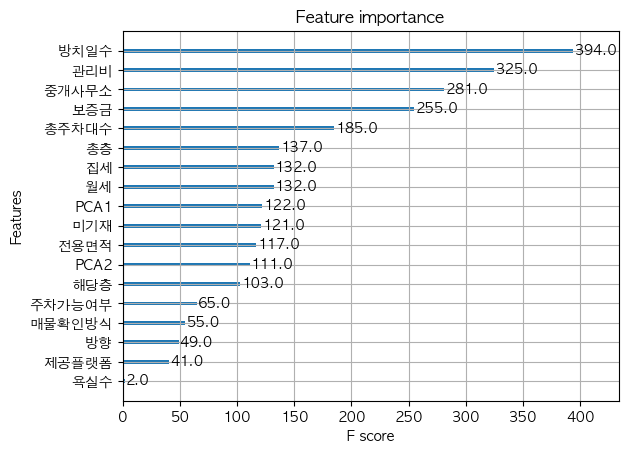

In [172]:
# fig, ax = plt.subplots(figsize=(10, 12))

# plot_importance(xgb_wrapper, ax=ax)
plot_importance(xgb_wrapper)
plt.show()

In [173]:


ws50_preds = xgb_wrapper.predict(X_test)
ws50_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

len(ws50_preds)
test_data['ID']

df = pd.concat([pd.Series(test_data['ID'], name="ID"), pd.DataFrame(ws50_preds, columns=["허위매물여부"])], axis=1)
print(df)

# df.to_csv("/Users/pycode/project/output.csv", index = False)

KeyError: 'ID'

# 📍📍 LightGBM

### GridSearchCV 사용 X

In [174]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, early_stopping_rounds=50)
# lgbm_wrapper = LGBMClassifier(n_estimators=400, colsample_bytree=0.98529, learning_rate=0.11714, max_depth=7, min_child_weight=1)
# lgbm_wrapper = LGBMClassifier(n_estimators=400, early_stopping_rounds=50, colsample_bytree=0.98529, learning_rate=0.11714, min_child_weight=1)

evals = [(X_tr, y_tr), (X_val, y_val)]

lgbm_wrapper.fit(X_tr, y_tr, eval_set=evals, eval_metric="logloss")
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[1]	training's binary_logloss: 0.651723	valid_1's binary_logloss: 0.652428
[2]	training's binary_logloss: 0.614116	valid_1's binary_logloss: 0.615665
[3]	training's binary_logloss: 0.579705	valid_1's binary_logloss: 0.582407
[4]	training's binary_logloss: 0.548361	valid_1's binary_logloss: 0.552356
[5]	training's binary_logloss: 0.519215	valid_1's binary_logloss: 0.524016
[6]	training's binary_logloss: 0.492733	valid_1's binary_logloss: 0.497835
[7]	training's binary_logloss: 0.46833	valid_1's binary_logloss: 0.474296
[8]	training's binary_logloss: 0.445193	valid_1's binary_logloss: 0.45132
[9]	training's binary_logloss: 0.42379	valid_1's binary_logloss: 0.430104
[10]	training's binary_logloss: 0.403741	valid_1's binary_logloss: 0.410465
[11]	training's binary_logloss: 0.385665	valid_1's binary_logloss: 0.391945
[12]	training's binary_logloss: 0.367937	v

In [25]:
# # fig, ax = plt.subplots(figsize=(10, 12))

# plot_importance(lgbm_wrapper)
# plt.show()

In [175]:

len(preds)
test['ID']

df = pd.concat([pd.Series(test['ID'], name="ID"), pd.DataFrame(preds, columns=["허위매물여부"])], axis=1)
print(df)

df.to_csv("/Users/pycode/project/output_lgbm_smotenc_pca.csv", index = False)

           ID  허위매물여부
0    TEST_000       0
1    TEST_001       0
2    TEST_002       1
3    TEST_003       0
4    TEST_004       0
..        ...     ...
608  TEST_608       0
609  TEST_609       0
610  TEST_610       0
611  TEST_611       0
612  TEST_612       0

[613 rows x 2 columns]
